<a href="https://colab.research.google.com/github/IreneLedyaeva/CAP-5610/blob/master/HW3/problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tuning with data augmentation

### Downloading the cats vs dogs data

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-11 18:29:53--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  38.7MB/s    in 1.7s    

2019-04-11 18:29:55 (38.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Extracting the data locally in /tmp

In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

### Training and validation directories

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### Loading the convolutional base of VGG19

In [4]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 12s 0us/step


### Freezing the convolutional base weights

In [0]:
conv_base.trainable = False

### Building the model by adding new dense layers

In [6]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


### Data augmentation
Validation data should not be augmented

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Fine-tuning the model

In [8]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


### Running the model

In [9]:
from keras import optimizers

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=25)

50/50 [==============================] - 524s 10s/step - loss: 0.6008 - acc: 0.6940 - val_loss: 0.4268 - val_acc: 0.8240
Epoch 2/30
50/50 [==============================] - 522s 10s/step - loss: 0.4828 - acc: 0.7740 - val_loss: 0.3443 - val_acc: 0.8480
Epoch 3/30
50/50 [==============================] - 521s 10s/step - loss: 0.3630 - acc: 0.8400 - val_loss: 0.2780 - val_acc: 0.8660
Epoch 4/30
50/50 [==============================] - 520s 10s/step - loss: 0.3579 - acc: 0.8430 - val_loss: 0.2428 - val_acc: 0.8860
Epoch 5/30
50/50 [==============================] - 520s 10s/step - loss: 0.3325 - acc: 0.8540 - val_loss: 0.4149 - val_acc: 0.8320
Epoch 6/30
50/50 [==============================] - 520s 10s/step - loss: 0.3076 - acc: 0.8720 - val_loss: 0.3158 - val_acc: 0.8720
Epoch 7/30
50/50 [==============================] - 520s 10s/step - loss: 0.3022 - acc: 0.8680 - val_loss: 0.2156 - val_acc: 0.8960
Epoch 8/30
50/50 [==============================] - 520s 10s/step - loss: 0.2948 - acc:

### Checking overfitting

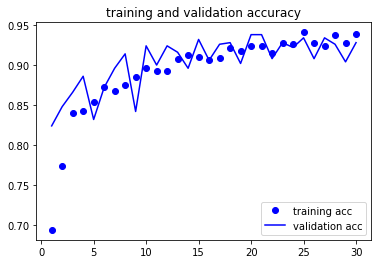

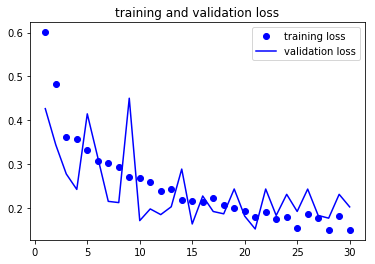

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

### Printing out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=25)

In [13]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.14749478396959603
Validation accuracy: 0.9459999966621399


### Saving the model

In [0]:
model_fname = 'cats_and_dogs_pretrained_fine_tune.h5' 
model.save(model_fname)

from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)